In [7]:
# Libraries and settings
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = "" # with this line we don't use the GPU to process
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
import time
from tqdm.notebook import tqdm

DATABASE_ROOT = Path("Dataset")
OUT_ROOT = Path("preprocessed_variants_2")
OUT_ROOT.mkdir(exist_ok=True)
SEED = 42
print("DATABASE_ROOT:", DATABASE_ROOT.resolve())
print("OUT_ROOT:", OUT_ROOT.resolve())


DATABASE_ROOT: C:\Users\jjgca\Documents\2025-2\Machine Learning Aplicado\Personal\Dataset
OUT_ROOT: C:\Users\jjgca\Documents\2025-2\Machine Learning Aplicado\Personal\preprocessed_variants_2


In [2]:
# Folders and list .jpg files
folders = sorted([folder for folder in DATABASE_ROOT.iterdir() if folder.is_dir()])
class_names = [folder.name for folder in folders]
print("Classes detected: ", class_names,"\n")
path_per_class = {}
total = 0
for folder in folders:
    images = []
    for image in folder.glob("*"):
        if image.suffix.lower() == ".jpg":
            images.append(image)
    images = sorted(images)
    path_per_class[folder.name] = images
    total += len(images)
    print(f"{folder.name}: {len(images)} .jpg files")
print("\nTotal images .jpg selected:", total)

Classes detected:  ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'] 

Tomato___Bacterial_spot: 2127 .jpg files
Tomato___Early_blight: 1000 .jpg files
Tomato___healthy: 1591 .jpg files
Tomato___Late_blight: 1908 .jpg files
Tomato___Leaf_Mold: 952 .jpg files
Tomato___Septoria_leaf_spot: 1771 .jpg files
Tomato___Spider_mites Two-spotted_spider_mite: 1676 .jpg files
Tomato___Target_Spot: 1404 .jpg files
Tomato___Tomato_mosaic_virus: 373 .jpg files
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 5357 .jpg files

Total images .jpg selected: 18159


In [3]:
# Grid: resolutions and jpeg qualities
resolutions = [(50,50), (64,64)]
jpeg_qualities = [50,70,90,95]

variants = []
for resolution in resolutions:
    for quality in jpeg_qualities:
        name = f"resolution_{resolution[0]}X{resolution[1]}_quality_{quality}"
        variants.append({'name':name, 'size':resolution, 'quality':quality})
print("Variants to create:", len(variants),"\n")
for variant  in variants:
    print(variant['name'])

Variants to create: 8 

resolution_50X50_quality_50
resolution_50X50_quality_70
resolution_50X50_quality_90
resolution_50X50_quality_95
resolution_64X64_quality_50
resolution_64X64_quality_70
resolution_64X64_quality_90
resolution_64X64_quality_95


In [4]:
# Utilities - functions
def save_jpeg_RGB(img_pil, out_path: Path, quality:int):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    img = img_pil.convert('RGB')
    img.save(out_path,format='JPEG',quality=quality, optimize=True)
    return out_path.stat().st_size

In [5]:
# Preprocesses
results = []
start_all = time.perf_counter()

for variant in variants:
    start_time = time.perf_counter()
    print(f"\nVariant Preprocessing: {variant['name']}")
    out_base= OUT_ROOT/variant['name']
    total_images = sum(len(value) for value in path_per_class.values())
    pbar = tqdm(total=total_images)
    errors = 0
    for clss, paths in path_per_class.items():
        for path in paths:
            try:
                image = Image.open(path).convert('RGB')
            except Exception as e:
                errors += 1
                print(f"error: {e}")
                pbar.update(1)
                continue
            # resize
            image_resized = image.resize(variant['size'], resample=Image.Resampling.LANCZOS)
            out_path = out_base/clss/path.name
            try:
                size_bytes = save_jpeg_RGB(image_resized, out_path, variant['quality'])
            except Exception as e:
                errors+=1
                print(f"error: {e}")
            pbar.update(1)
    pbar.close()
    end_time = time.perf_counter()
    time_per_variant = end_time-start_time
    print(f"Time needed: {time_per_variant:.4f} seconds")
    results.append({
        'variant':variant['name'],
        'resolution':variant['size'][0]+variant['size'][1],
        'quality':variant['quality'],
        'images':total_images,
        'errors':errors,
        'time_seconds':round(time_per_variant,4)
    })
end_all = time.perf_counter()
print(f"\nPreprocess completed in {end_all - start_all:.4f} seconds")
# Save results in csv
df = pd.DataFrame(results)
df.to_csv(OUT_ROOT/"variant_result_status.csv",index=False)
df


Variant Preprocessing: resolution_50X50_quality_50


  0%|          | 0/18159 [00:00<?, ?it/s]

Time needed: 194.0335 seconds

Variant Preprocessing: resolution_50X50_quality_70


  0%|          | 0/18159 [00:00<?, ?it/s]

Time needed: 49.4637 seconds

Variant Preprocessing: resolution_50X50_quality_90


  0%|          | 0/18159 [00:00<?, ?it/s]

Time needed: 49.7815 seconds

Variant Preprocessing: resolution_50X50_quality_95


  0%|          | 0/18159 [00:00<?, ?it/s]

Time needed: 50.5781 seconds

Variant Preprocessing: resolution_64X64_quality_50


  0%|          | 0/18159 [00:00<?, ?it/s]

Time needed: 51.8543 seconds

Variant Preprocessing: resolution_64X64_quality_70


  0%|          | 0/18159 [00:00<?, ?it/s]

Time needed: 51.6054 seconds

Variant Preprocessing: resolution_64X64_quality_90


  0%|          | 0/18159 [00:00<?, ?it/s]

Time needed: 46.1959 seconds

Variant Preprocessing: resolution_64X64_quality_95


  0%|          | 0/18159 [00:00<?, ?it/s]

Time needed: 50.8136 seconds

Preprocess completed in 544.3269 seconds


,variant,resolution,quality,images,errors,time_seconds
0,resolution_50X50_quality_50,100,50,18159,0,194.0335
1,resolution_50X50_quality_70,100,70,18159,0,49.4637
2,resolution_50X50_quality_90,100,90,18159,0,49.7815
3,resolution_50X50_quality_95,100,95,18159,0,50.5781
4,resolution_64X64_quality_50,128,50,18159,0,51.8543
5,resolution_64X64_quality_70,128,70,18159,0,51.6054
6,resolution_64X64_quality_90,128,90,18159,0,46.1959
7,resolution_64X64_quality_95,128,95,18159,0,50.8136


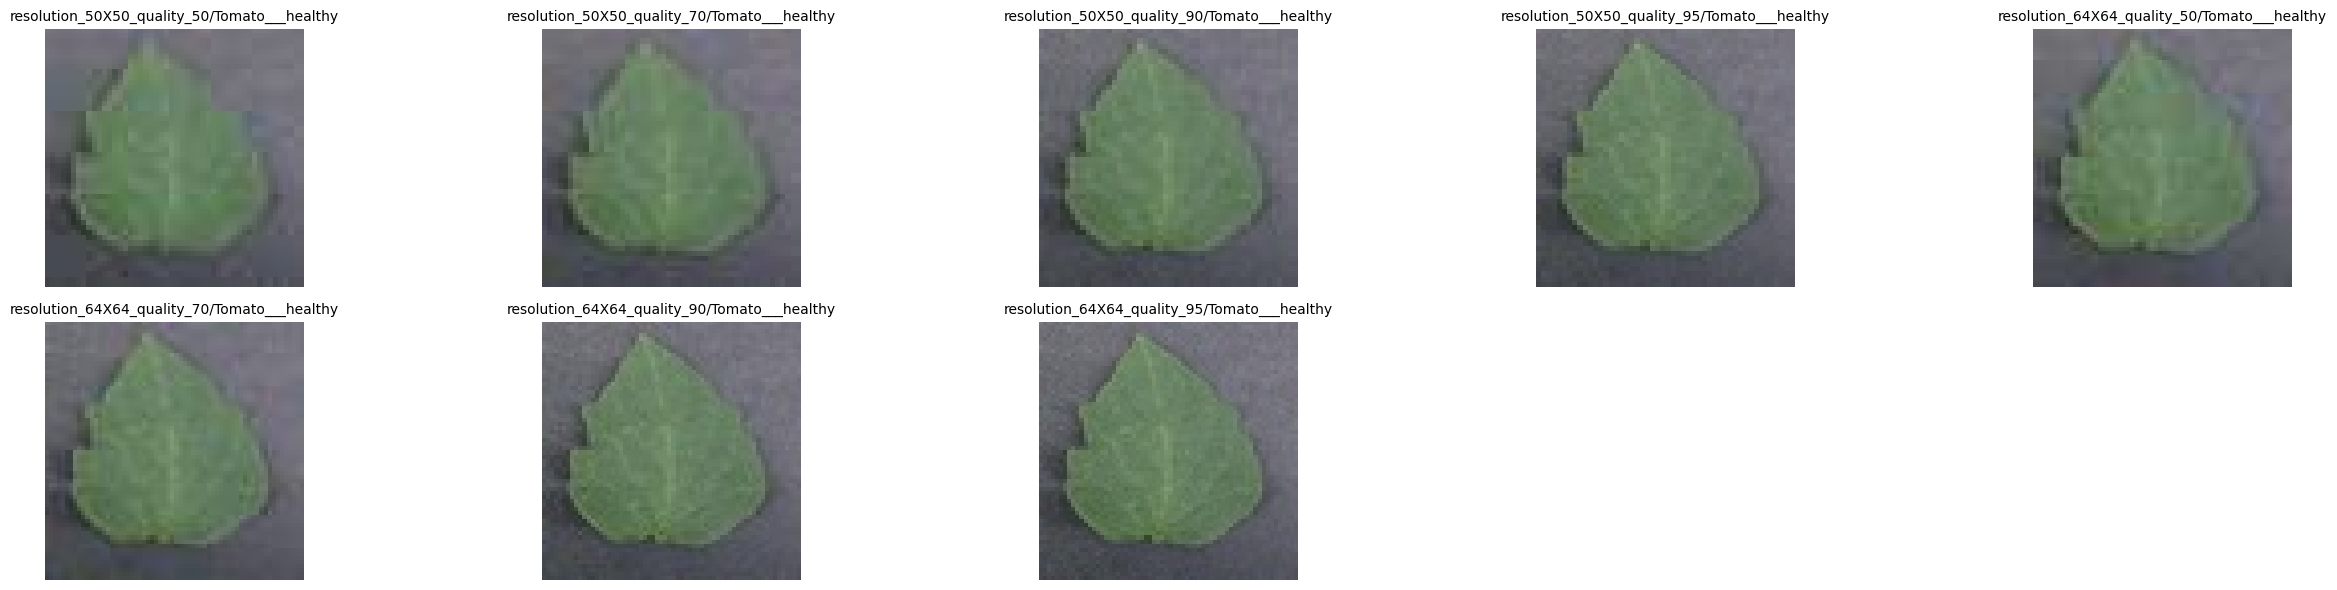

In [6]:
# Screen example per variant
images_example = []
titles = []
for folder2 in sorted(OUT_ROOT.iterdir()):
    if folder2.is_dir():
        folders3 = sorted([folder3 for folder3 in folder2.iterdir() if folder3.is_dir()])
        if not folders3:
            continue
        folder3 = folders3[2]
        image_file = sorted(folder3.glob("*"))
        img = Image.open(image_file[0]).convert("RGB")
        images_example.append(img)
        titles.append(f"{folder2.name}/{folder3.name}")
    
num_images = len(images_example)
cols = 5
rows = (num_images+cols-1)//cols
plt.figure(figsize=(cols*5,rows*3))
for i, (img, title) in enumerate(zip(images_example, titles)):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(title, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()